**Lindbald Master Equation and Hamiltonian**

---

$$ \dot\rho=-i[H_{1},\rho]+\gamma_{1D}[2\sigma_{1}\rho\sigma_{1}^{\dagger}-\sigma_{1}^{\dagger}\sigma_{1}\rho-\rho\sigma_{1}^{\dagger}\sigma_{1}] $$

$$ H_{1}=[\omega_{0}+A_{j}(t)]\sigma_{1}^{\dagger}\sigma_{1}-\frac{i\Omega_{R}}{2}(e^{-i\varepsilon t}\sigma_{1}^{\dagger}-H.c) $$

**Hamiltonian with Detuning**



---
$$ U(t)=e^{i\epsilon t\sigma_{1}^{\dagger}\sigma_{1}} $$

$$ H_{1}^{'}=U^{\dagger}H_{1}U - iU^{\dagger}\frac{\partial U}{\partial t} $$

$$ iU^{\dagger}\frac{\partial U}{\partial t} = i(-i\epsilon)\sigma_{1}^{\dagger}\sigma_{1} = -\epsilon\sigma_{1}^{\dagger}\sigma_{1} $$

$$ U^{\dagger}(e^{-i\epsilon t}\sigma_{1}^{\dagger})U = e^{-i\epsilon t} \cdotp e^{i\epsilon t} \sigma_{1}^{\dagger} = \sigma_{1}^{\dagger}$$

$$ \delta = \omega_{0} - \epsilon $$

$$ H^{'}_{1}(t) = [\delta + A_{j}(t)]\sigma_{1}^{\dagger}\sigma_{1} - \frac{i\Omega_{R}}{2}(\sigma_{1}^{\dagger} - \sigma_{1}) $$


**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.linalg import expm
from tqdm import tqdm
from mpmath import mp, invertlaplace, mpc, mpf
from scipy import special

%matplotlib inline

In [2]:
gamma_1D = 1.0       # Decay rate
Omega = 5 * gamma_1D # Modulation frequency
A = 0.5 * gamma_1D # Modulation amplitude
D = 0.5        # Detuning
Omega_R = 0.1 * gamma_1D  # Weak driving
alpha = np.pi

psi_ground = np.array([0, 1], dtype=complex)  # Initial ground state, outer product

t_final = 50 / gamma_1D
times = np.linspace(0, t_final, 2000)  # More points for better FFT resolution

In [3]:
def pauli_matrices():
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)

    # Lowering operator (sigma_-)
    sigma = np.array([[0, 1], [0, 0]], dtype=complex)

    # Raising operator (sigma_+)
    sigma_dag = np.array([[0, 0], [1, 0]], dtype=complex)

    # Number operator
    n = sigma_dag @ sigma

    # Identity
    I = np.eye(2, dtype=complex)

    return sigma_x, sigma_y, sigma_z, sigma, sigma_dag, n, I

sigma_x, sigma_y, sigma_z, sigma, sigma_dag, n, I = pauli_matrices()


def A_modulation(t):
    return A * np.cos((Omega * t) + alpha)


def hamiltonian(t):
    A_t = A_modulation(t)
    return (D + A_t) * n - ((1j * Omega_R) / 2) * (sigma_dag - sigma)


def commutator(A, B):
    return (A @ B) - (B @ A)


def lindblad_term(rho, s):
    s_dag = s.conj().T
    return 2 * s @ rho @ s_dag - s_dag @ s @ rho - rho @ s_dag @ s


def lindblad_master_equation(t, rho_vec):
    rho = rho_vec.reshape((2, 2))
    H = hamiltonian(t)  # Hamiltonian at time (t)
    drho_dt = (-1j * commutator(H, rho)) + (gamma_1D * lindblad_term(rho, sigma))
    return drho_dt.flatten()

def simulate_lindblad(times, initial_state):
    # Initial density matrix ρ₀ = |ψ₀⟩⟨ψ₀|
    rho_0 = np.outer(initial_state, initial_state.conj())
    rho_0_vec = rho_0.flatten()

    # Solve the master equation
    solution = solve_ivp(
        lindblad_master_equation,
        t_span=(times[0], times[-1]),
        y0=rho_0_vec,
        t_eval=times,
        method='DOP853',
        rtol=1e-10,
        atol=1e-12
    )

    # Compute expectation values
    sigma_minus_expect = np.zeros(len(times), dtype=complex)
    sigma_plus_expect = np.zeros(len(times), dtype=complex)
    sigma_z_expect = np.zeros(len(times), dtype=complex)
    population_excited = np.zeros(len(times))
    population_ground = np.zeros(len(times))
    purity = np.zeros(len(times))

    for i, t in enumerate(times):
        rho = solution.y[:, i].reshape((2, 2))

        # Expectation values: ⟨O⟩ = Tr(ρO)
        sigma_minus_expect[i] = np.trace(rho @ sigma)
        sigma_plus_expect[i] = np.trace(rho @ sigma_dag)
        sigma_z_expect[i] = np.trace(rho @ sigma_z)

        # Populations
        population_excited[i] = rho[1, 1].real  # ⟨1|ρ|1⟩
        population_ground[i] = rho[0, 0].real   # ⟨0|ρ|0⟩

        # Purity: Tr(ρ²)
        purity[i] = np.trace(rho @ rho).real

    expectation_values = {
        'sigma_minus': sigma_minus_expect,
        'sigma_plus': sigma_plus_expect,
        'sigma_z': sigma_z_expect,
        'population_excited': population_excited,
        'population_ground': population_ground,
        'purity': purity
    }

    return solution, expectation_values

In [4]:
# @title
def plot_lindblad_expectation_values(times, expect_vals):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Time domain plots
    axes[0, 0].plot(times * gamma_1D, expect_vals['sigma_minus'].real, 'b-',
                    linewidth=2, label='Re⟨σ₋⟩')
    axes[0, 0].plot(times * gamma_1D, expect_vals['sigma_minus'].imag, 'r--',
                    linewidth=2, label='Im⟨σ₋⟩')
    axes[0, 0].set_xlabel('Time (1/γ₁D)', fontsize=12)
    axes[0, 0].set_ylabel('⟨σ₋(t)⟩', fontsize=12)
    axes[0, 0].set_title('Lindblad: ⟨σ₋(t)⟩', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(times * gamma_1D, expect_vals['sigma_plus'].real, 'b-',
                    linewidth=2, label='Re⟨σ₊⟩')
    axes[0, 1].plot(times * gamma_1D, expect_vals['sigma_plus'].imag, 'r--',
                    linewidth=2, label='Im⟨σ₊⟩')
    axes[0, 1].set_xlabel('Time (1/γ₁D)', fontsize=12)
    axes[0, 1].set_ylabel('⟨σ₊(t)⟩', fontsize=12)
    axes[0, 1].set_title('Lindblad: ⟨σ₊(t)⟩', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].plot(times * gamma_1D, expect_vals['sigma_z'].real, 'g-', linewidth=2)
    axes[1, 0].axhline(y=-1, color='k', linestyle=':', alpha=0.5, label='Ground')
    axes[1, 0].axhline(y=1, color='k', linestyle=':', alpha=0.5, label='Excited')
    axes[1, 0].set_xlabel('Time (1/γ₁D)', fontsize=12)
    axes[1, 0].set_ylabel('⟨σ_z(t)⟩', fontsize=12)
    axes[1, 0].set_title('Lindblad: ⟨σ_z(t)⟩', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].plot(times * gamma_1D, expect_vals['population_excited'], 'r-',
                    linewidth=2, label='Excited |1⟩')
    axes[1, 1].plot(times * gamma_1D, expect_vals['population_ground'], 'b-',
                    linewidth=2, label='Ground |0⟩')
    axes[1, 1].plot(times * gamma_1D, expect_vals['purity'], 'purple',
                    linewidth=2, linestyle='--', label='Purity Tr(ρ²)', alpha=0.7)
    axes[1, 1].set_xlabel('Time (1/γ₁D)', fontsize=12)
    axes[1, 1].set_ylabel('Population / Purity', fontsize=12)
    axes[1, 1].set_title('Populations and Purity', fontsize=14, fontweight='bold')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([-0.1, 1.1])

    plt.suptitle(f'Lindblad Master Equation (Ω={Omega:.1f}γ₁D, A={A:.3f}γ₁D)',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()

    # ===== CORRECTED FFT PLOT =====
    fig_fft, ax = plt.subplots(1, 1, figsize=(14, 6))

    dt = times[1] - times[0]
    N = len(times)

    # Compute FFT
    freqs = np.fft.fftfreq(N, dt)
    freqs_shifted = np.fft.fftshift(freqs)

    fft_sigma_minus = np.fft.fftshift(np.fft.fft(expect_vals['sigma_minus']))
    fft_sigma_plus = np.fft.fftshift(np.fft.fft(expect_vals['sigma_plus']))
    fft_sigma_z = np.fft.fftshift(np.fft.fft(expect_vals['sigma_z']))

    mag_sigma_minus = np.abs(fft_sigma_minus)
    mag_sigma_plus = np.abs(fft_sigma_plus)
    mag_sigma_z = np.abs(fft_sigma_z)

    # CORRECTED: Normalize frequency by gamma_1D (natural frequency unit)
    freq_normalized = (freqs_shifted / gamma_1D) * (2*np.pi)

    ax.semilogy(freq_normalized, mag_sigma_minus, 'b-',
                linewidth=2, label='|FFT[⟨σ₋⟩]|', alpha=0.8)
    ax.semilogy(freq_normalized, mag_sigma_plus, 'r-',
                linewidth=2, label='|FFT[⟨σ₊⟩]|', alpha=0.8)
    ax.semilogy(freq_normalized, mag_sigma_z, 'g-',
                linewidth=2, label='|FFT[⟨σz⟩]|', alpha=0.8)

    # Mark modulation frequency sidebands
    for n in range(-2, 3):
        freq_sideband = n * Omega / gamma_1D
        ax.axvline(x=freq_sideband, color='gray', linestyle=':', alpha=0.3)

    ax.axvline(x=Omega/gamma_1D, color='k', linestyle='--', alpha=0.7,
               label=f'±Ω = ±{Omega/gamma_1D:.1f}γ₁D')
    ax.axvline(x=-Omega/gamma_1D, color='k', linestyle='--', alpha=0.7)

    ax.set_xlabel('Frequency (ω/γ₁D)', fontsize=14)
    ax.set_ylabel('|FFT| (log scale)', fontsize=14)
    ax.set_title(f'Frequency Spectrum (Ω={Omega/gamma_1D:.1f}γ₁D)',
                 fontsize=15, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, which='both')
    ax.set_xlim([-15, 15])

    plt.tight_layout()

    return fig, fig_fft

Running Lindblad master equation simulation...
Simulation complete!


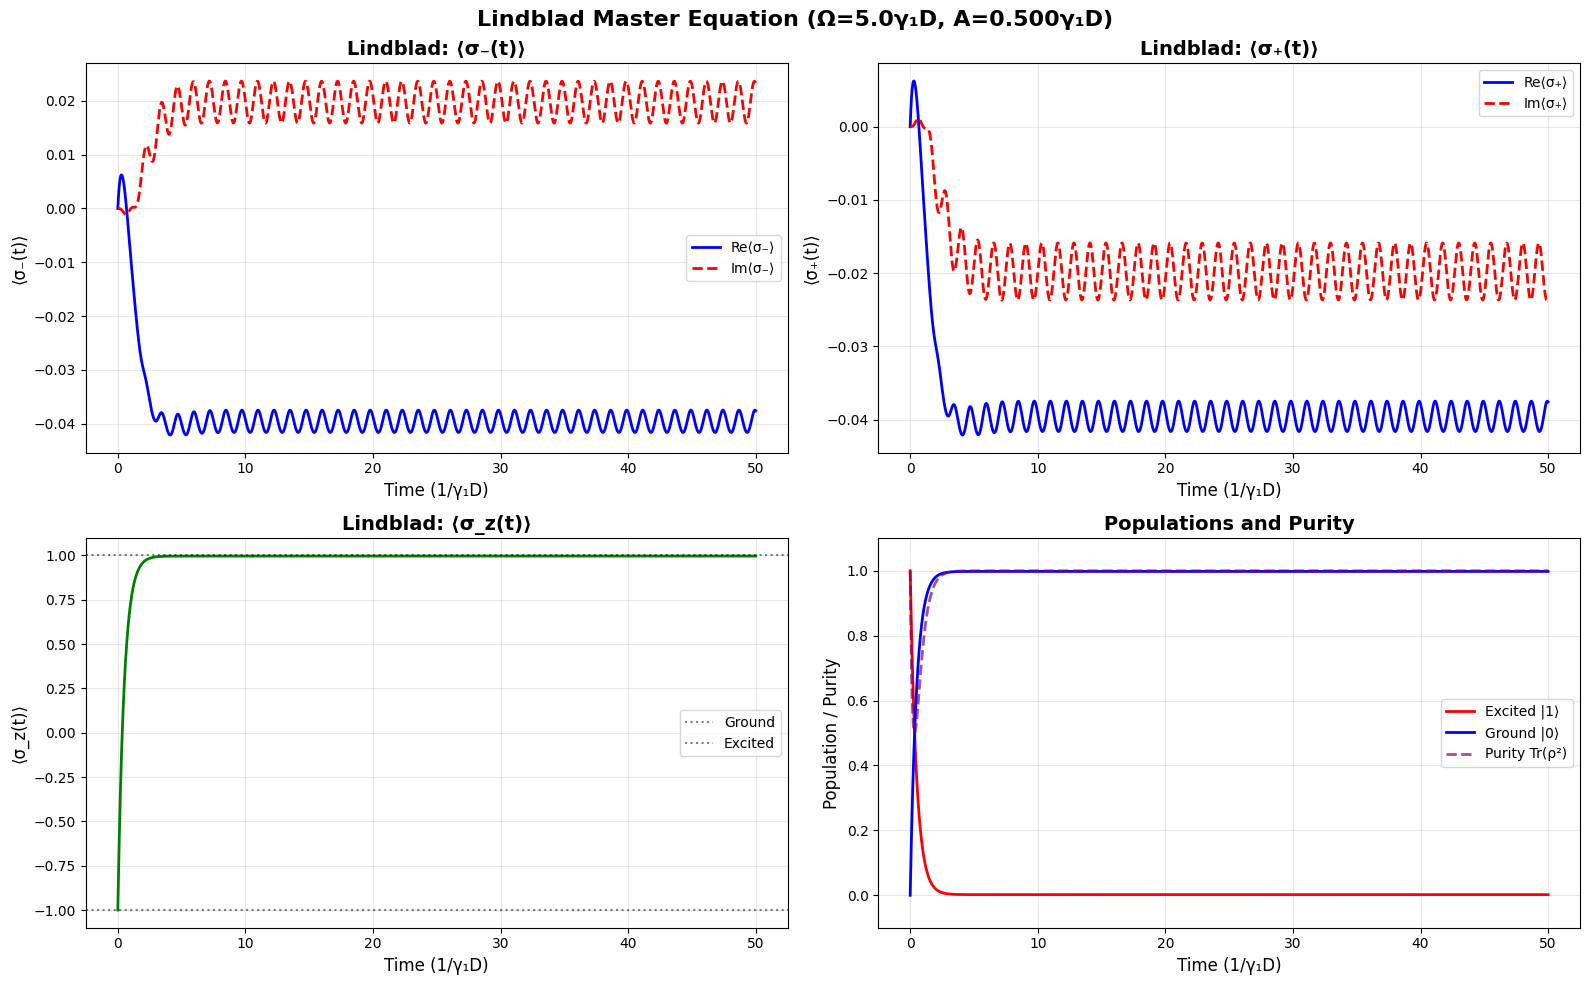

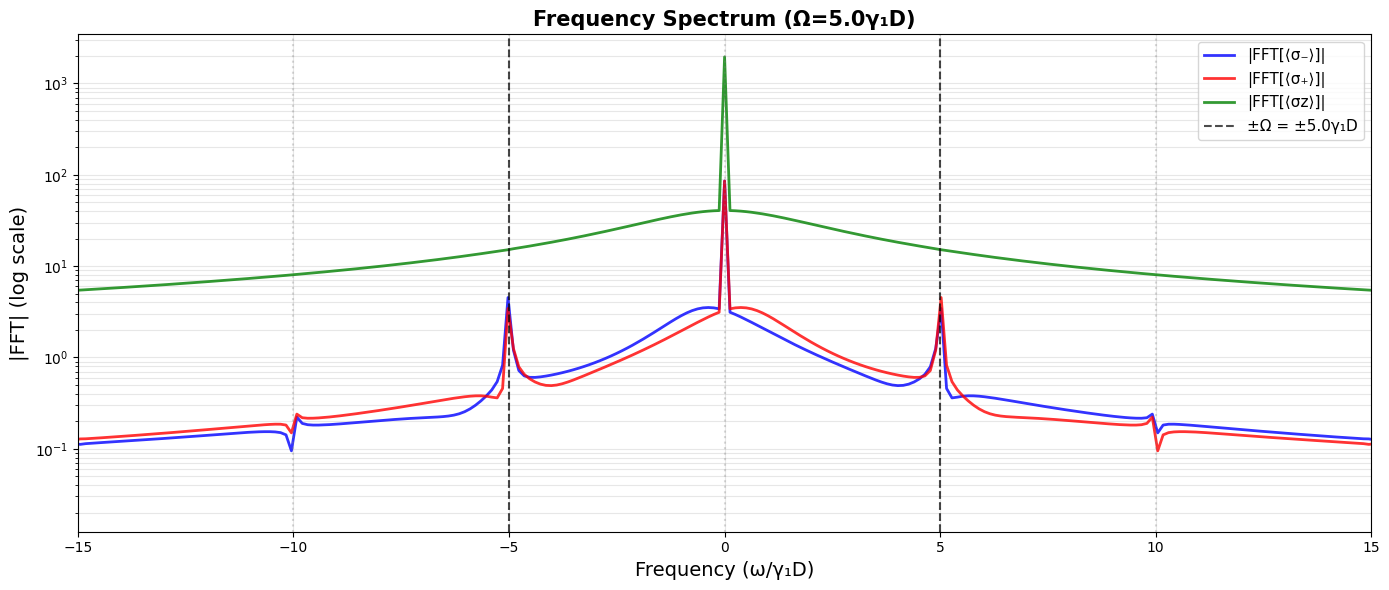

In [5]:
# Run Lindblad simulation
print("Running Lindblad master equation simulation...")
lindblad_solution, lindblad_expect = simulate_lindblad(times, psi_ground)
print("Simulation complete!")

fig_time, fig_freq = plot_lindblad_expectation_values(times, lindblad_expect)
plt.show()